In [ ]:
import pandas as pd
import numpy as np
import transformers
import nltk
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import accuracy_score
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

import pandas as pd
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import re
from sklearn.preprocessing import LabelEncoder

In [ ]:
# Download NLTK resources
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/dinesh/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /Users/dinesh/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [ ]:
# Load the data
df = pd.read_json('News_Category_Dataset_v32.json', lines=True)

In [ ]:
# Preprocess the data
df['category'] = df['category'].replace({"THE WORLDPOST": "WORLDPOST", "GREEN": "ENVIRONMENT"})
encoder = LabelEncoder()
df['categoryEncoded'] = encoder.fit_transform(df['category'])

# Function to clean and preprocess text
def clean_text(text):
    text = text.lower()  # Convert to lowercase
    text = re.sub(r'[^\w\s]', '', text)  # Remove punctuation
    text = re.sub(r'\s+', ' ', text)  # Replace multiple spaces with a single space
    return text

df['headline'] = df['headline'].apply(clean_text)
df['short_description'] = df['short_description'].apply(clean_text)
df['text'] = df['headline'] + " " + df['short_description']

# Advanced text processing with stopwords removal and lemmatization
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

def advanced_clean_text(text):
    words = text.split()
    filtered_words = [word for word in words if word not in stop_words]
    lemmatized_words = [lemmatizer.lemmatize(word) for word in filtered_words]
    return ' '.join(lemmatized_words)

df['text'] = df['text'].apply(advanced_clean_text)

In [ ]:
# Selecting only 5 categories: Politics, Entertainment, Sports, Business, and Tech
selected_categories = ['POLITICS', 'SPORTS', 'TECH','ENVIRONMENT','CRIME']

# Filtering the DataFrame to include only the selected categories
df_selected = df[df['category'].isin(selected_categories)]

# Limiting the number of records for each category to 200
# Ensuring consistent sampling by setting a random state
df_sampled = df_selected.groupby('category').apply(lambda x: x.sample(n=min(len(x),500), random_state=42)).reset_index(drop=True)


In [ ]:
def preprocess_text(text):
    # Normalize the text by lowering the case and removing unwanted characters
    text = text.lower()
    text = re.sub(r'[^\w\s]', '', text)  # Remove punctuation
    text = re.sub(r'\s+', ' ', text)  # Replace multiple spaces with a single space

    # Tokenization and removing stopwords and lemmatizing
    tokens = text.split()
    tokens = [lemmatizer.lemmatize(word) for word in tokens if word not in stop_words]

    # Rejoin tokens into a single string
    return ' '.join(tokens)

df_sampled['text'] = df_sampled['text'].apply(preprocess_text)

In [ ]:
from sklearn.model_selection import train_test_split

# Split the data into train and test sets
# Using a stratified split to maintain the distribution of categories in both training and testing datasets
X_train, X_test, y_train, y_test = train_test_split(
    df_sampled['text'],
    df_sampled['categoryEncoded'],
    test_size=0.1,
    random_state=2020,
    stratify=df_sampled['categoryEncoded']
)

In [ ]:
from transformers import BertTokenizer, TFBertModel
import tensorflow as tf

# Ensure that TensorFlow uses GPU if available for faster processing
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        # Set TensorFlow to use only the first GPU
        tf.config.experimental.set_visible_devices(gpus[0], 'GPU')
        tf.config.experimental.set_memory_growth(gpus[0], True)
    except RuntimeError as e:
        # Exception handling if GPU settings fail
        print(e)

# Load the BERT tokenizer and model
tokenizer = BertTokenizer.from_pretrained('bert-large-uncased')
model = TFBertModel.from_pretrained('bert-large-uncased')


Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions w

In [ ]:
import tensorflow as tf

def generate_bert_embeddings(texts, batch_size=32):
    embeddings = []

    # Process texts in batches to manage memory more efficiently and handle larger datasets
    for i in range(0, len(texts), batch_size):
        batch_texts = texts[i:i + batch_size]
        input_ids = tokenizer(batch_texts.tolist(), padding=True, truncation=True, max_length=128, return_tensors="tf")["input_ids"]
        outputs = model(input_ids)
        batch_embeddings = outputs.last_hidden_state[:, 0, :]
        embeddings.append(batch_embeddings)

    # Concatenate all batch embeddings into a single array
    return tf.concat(embeddings, axis=0).numpy()


In [ ]:
# Generate BERT embeddings for train and test data using the enhanced function
# It's important to determine the optimal batch size based on your system's GPU memory limits.
optimal_batch_size = 16  # Adjust based on your system's configuration and available memory

X_train_bert_embeddings = generate_bert_embeddings(X_train, batch_size=optimal_batch_size)
X_test_bert_embeddings = generate_bert_embeddings(X_test, batch_size=optimal_batch_size)


In [ ]:
X_train_bert_embeddings

array([[ 0.16844004,  0.19314417, -0.35544074, ..., -0.24286261,
        -0.75131655, -0.06193525],
       [ 0.35270682,  0.11434144, -0.00671138, ..., -0.02417824,
        -0.9251119 ,  0.25538254],
       [ 0.38760746,  0.2746205 , -0.4010413 , ..., -0.5325816 ,
        -0.6647117 , -0.05954994],
       ...,
       [ 0.19240364,  0.07807143, -0.25748652, ...,  0.01135832,
        -0.9471726 ,  0.38475123],
       [ 0.09332949,  0.27732724,  0.34846085, ...,  0.17343712,
        -1.1221265 ,  0.23207384],
       [ 0.33546636,  0.26112115, -0.21662317, ..., -0.59593016,
        -0.7075991 , -0.23570082]], dtype=float32)

In [ ]:
X_test_bert_embeddings

array([[ 0.3994876 ,  0.23021576, -0.04793626, ..., -0.05326822,
        -0.79174703,  0.07533461],
       [ 0.49320704, -0.00601535, -0.03014916, ..., -0.5539528 ,
        -0.64020544, -0.10925725],
       [ 0.08141494,  0.24972785,  0.14362511, ..., -0.0035841 ,
        -1.0442411 ,  0.06072181],
       ...,
       [ 0.10970318, -0.34645876, -0.22718942, ..., -0.6792685 ,
        -0.7321009 ,  0.5329354 ],
       [ 0.1820756 ,  0.14206058, -0.30464983, ..., -0.5224906 ,
        -0.90556395,  0.07734889],
       [ 0.26791093,  0.5765736 ,  0.10232454, ..., -0.2159785 ,
        -0.7294998 , -0.06209806]], dtype=float32)

In [ ]:
from sklearn.preprocessing import StandardScaler

# Initialize the StandardScaler
scaler = StandardScaler()

# Exception handling to manage potential issues during scaling
try:
    # Scale the input features for SVM and KNN
    X_train_scaled = scaler.fit_transform(X_train_bert_embeddings)
    X_test_scaled = scaler.transform(X_test_bert_embeddings)
except Exception as e:
    print(f"An error occurred while scaling the features: {e}")


In [ ]:
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
import joblib

# SVM hyperparameters
svm_params = {'C': [0.1, 1, 10], 'gamma': ['scale', 'auto', 0.001, 0.01, 0.1]}
svm_classifier = GridSearchCV(SVC(kernel='linear'), svm_params, cv=3, verbose=2, n_jobs=joblib.cpu_count() - 1)

# Training SVM classifier with hyperparameter optimization
try:
    svm_classifier.fit(X_train_scaled, y_train)
    print(f"Best parameters found: {svm_classifier.best_params_}")
    print(f"Best cross-validation score: {svm_classifier.best_score_:.2f}")
except Exception as e:
    print(f"An error occurred while training SVM: {e}")


Fitting 3 folds for each of 15 candidates, totalling 45 fits


[CV] END ..................................C=0.1, gamma=auto; total time=   2.1s
[CV] END .................................C=0.1, gamma=0.001; total time=   2.1s
[CV] END .................................C=0.1, gamma=scale; total time=   2.2s
[CV] END ..................................C=0.1, gamma=auto; total time=   2.2s
[CV] END ..................................C=0.1, gamma=auto; total time=   2.2s
[CV] END .................................C=0.1, gamma=scale; total time=   2.3s
[CV] END .................................C=0.1, gamma=scale; total time=   2.5s
[CV] END .................................C=0.1, gamma=0.001; total time=   1.7s
[CV] END .................................C=0.1, gamma=0.001; total time=   1.8s
[CV] END ..................................C=0.1, gamma=0.01; total time=   1.8s
[CV] END ..................................C=0.1, gamma=0.01; total time=   1.8s
[CV] END ...................................C=0.1, gamma=0.1; total time=   1.7s
[CV] END ...................

In [ ]:
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

# Predict using optimized SVM classifier
svm_predictions = svm_classifier.predict(X_test_scaled)

# Calculate accuracy and other performance metrics
svm_accuracy = accuracy_score(y_test, svm_predictions)
precision, recall, fscore, _ = precision_recall_fscore_support(y_test, svm_predictions, average='weighted')

# Display the results
print("SVM Accuracy:", svm_accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F-Score:", fscore)
print("Best SVM Parameters:", svm_classifier.best_params_)


SVM Accuracy: 0.704
Precision: 0.7021119781989348
Recall: 0.704
F-Score: 0.7022812971342383
Best SVM Parameters: {'C': 0.1, 'gamma': 'scale'}


In [ ]:
# Define hyperparameters for KNN
knn_params = {'n_neighbors': [3, 5, 7], 'weights': ['uniform', 'distance']}
knn_classifier = GridSearchCV(KNeighborsClassifier(), knn_params, cv=3, verbose=2, n_jobs=joblib.cpu_count() - 1)

# Training KNN classifier with hyperparameter optimization
try:
    knn_classifier.fit(X_train_scaled, y_train)
    print(f"Best KNN Parameters: {knn_classifier.best_params_}")
except Exception as e:
    print(f"An error occurred during KNN training: {e}")

# Predict using optimized KNN classifier
try:
    knn_predictions = knn_classifier.predict(X_test_scaled)
    knn_accuracy = accuracy_score(y_test, knn_predictions)
    print("KNN Accuracy:", knn_accuracy)
except Exception as e:
    print(f"An error occurred during KNN prediction: {e}")

Fitting 3 folds for each of 6 candidates, totalling 18 fits
[CV] END .....................n_neighbors=3, weights=uniform; total time=   0.1s
[CV] END .....................n_neighbors=3, weights=uniform; total time=   0.1s
[CV] END .....................n_neighbors=3, weights=uniform; total time=   0.1s
[CV] END ....................n_neighbors=3, weights=distance; total time=   0.1s
[CV] END ....................n_neighbors=3, weights=distance; total time=   0.1s
[CV] END ....................n_neighbors=3, weights=distance; total time=   0.1s
[CV] END .....................n_neighbors=5, weights=uniform; total time=   0.1s
[CV] END .....................n_neighbors=5, weights=uniform; total time=   0.1s
[CV] END .....................n_neighbors=5, weights=uniform; total time=   0.1s
[CV] END ....................n_neighbors=5, weights=distance; total time=   0.1s
[CV] END .....................n_neighbors=7, weights=uniform; total time=   0.1s
[CV] END ....................n_neighbors=5, weigh

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Train RandomForestClassifier
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=0)
rf_classifier.fit(X_train_bert_embeddings, y_train)

# Predict using RandomForestClassifier
rf_predictions = rf_classifier.predict(X_test_bert_embeddings)
rf_accuracy = accuracy_score(y_test, rf_predictions)
rf_precision = precision_score(y_test, rf_predictions, average='weighted')
rf_recall = recall_score(y_test, rf_predictions, average='weighted')
rf_f1_score = f1_score(y_test, rf_predictions, average='weighted')

# Display the results
print("RandomForestClassifier Accuracy:", rf_accuracy)
print("Precision:", rf_precision)
print("Recall:", rf_recall)
print("F1 Score:", rf_f1_score)


RandomForestClassifier Accuracy: 0.692
Precision: 0.7085182024734265
Recall: 0.692
F1 Score: 0.6919129349352474


/opt/homebrew/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


RandomForestClassifier Accuracy: 0.69
GradientBoostingClassifier Accuracy: 0.72
LogisticRegression Accuracy: 0.76
SVM Accuracy: 0.73
KNeighborsClassifier Accuracy: 0.63


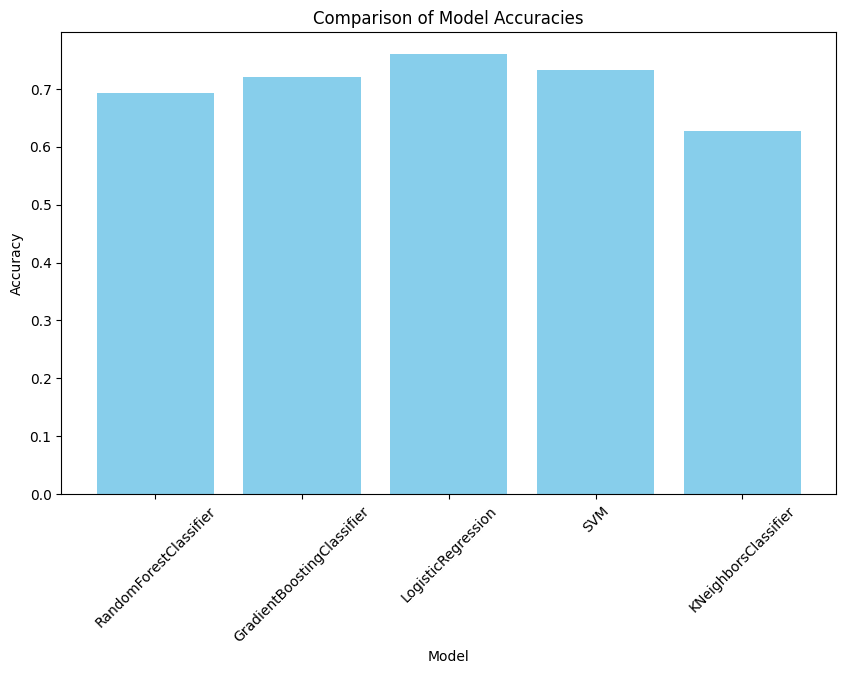

In [ ]:
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

# Define the models to be compared
models = {
    "RandomForestClassifier": RandomForestClassifier(n_estimators=100, random_state=0),
    "GradientBoostingClassifier": GradientBoostingClassifier(n_estimators=100, random_state=0),
    "LogisticRegression": LogisticRegression(max_iter=1000, random_state=0),
    "SVM": SVC(kernel='linear', random_state=0),
    "KNeighborsClassifier": KNeighborsClassifier(n_neighbors=5)
}

# Train and evaluate each model
accuracies = {}
for name, model in models.items():
    model.fit(X_train_bert_embeddings, y_train)  # Train model
    predictions = model.predict(X_test_bert_embeddings)  # Predict on the test set
    accuracies[name] = accuracy_score(y_test, predictions)  # Calculate accuracy

# Print accuracies for each model
for name, accuracy in accuracies.items():
    print(f"{name} Accuracy: {accuracy:.2f}")

# Visualization of the accuracies
plt.figure(figsize=(10, 6))
model_names = list(accuracies.keys())
model_accuracies = list(accuracies.values())
plt.bar(model_names, model_accuracies, color='skyblue')
plt.xlabel('Model')
plt.ylabel('Accuracy')
plt.title('Comparison of Model Accuracies')
plt.xticks(rotation=45)
plt.show()


In [ ]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score

# Assuming you've already split the data and have X_train_bert_embeddings, X_test_bert_embeddings, y_train, y_test

# Gradient Boosting
gbm_classifier = GradientBoostingClassifier(n_estimators=100, random_state=0)
gbm_classifier.fit(X_train_bert_embeddings, y_train)
gbm_predictions = gbm_classifier.predict(X_test_bert_embeddings)

# RandomForest
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=0)
rf_classifier.fit(X_train_bert_embeddings, y_train)
rf_predictions = rf_classifier.predict(X_test_bert_embeddings)

# Logistic Regression
lr_classifier = LogisticRegression(max_iter=1000, random_state=0)
lr_classifier.fit(X_train_bert_embeddings, y_train)
lr_predictions = lr_classifier.predict(X_test_bert_embeddings)

# SVM
svm_classifier = SVC(kernel='linear', random_state=0)
svm_classifier.fit(X_train_bert_embeddings, y_train)
svm_predictions = svm_classifier.predict(X_test_bert_embeddings)

# KNeighbors
knn_classifier = KNeighborsClassifier(n_neighbors=5)
knn_classifier.fit(X_train_bert_embeddings, y_train)
knn_predictions = knn_classifier.predict(X_test_bert_embeddings)


/opt/homebrew/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


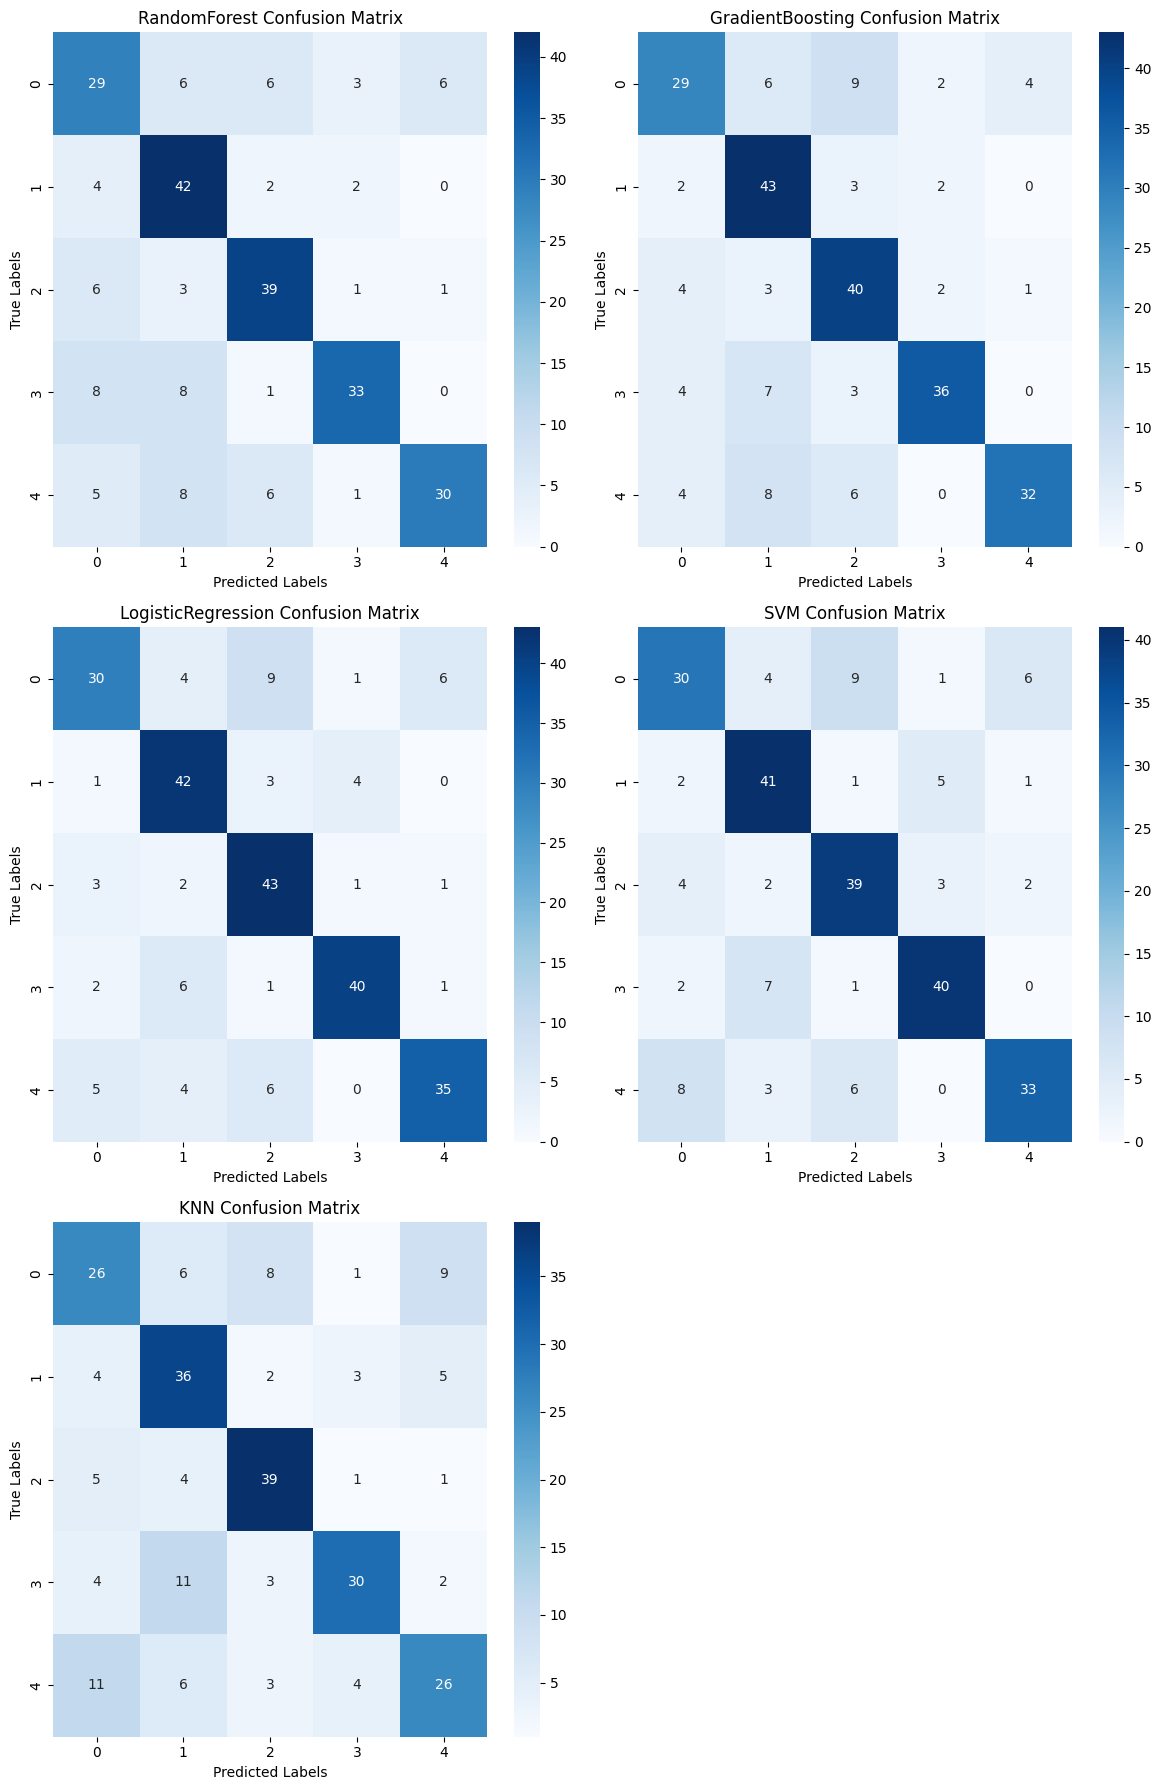

In [ ]:
rom sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Organize predictions into a dictionary
model_predictions = {
    "RandomForest": rf_predictions,
    "GradientBoosting": gbm_predictions,
    "LogisticRegression": lr_predictions,
    "SVM": svm_predictions,
    "KNN": knn_predictions
}

# Create subplots
fig, axes = plt.subplots(3, 2, figsize=(12, 18))
fig.delaxes(axes[2,1])  # Remove the last subplot if odd number of models

# Plot confusion matrices
for ax, (name, predictions) in zip(axes.flatten(), model_predictions.items()):
    conf_mat = confusion_matrix(y_test, predictions)
    # Find the top 5 labels/categories with the highest true positive counts
    top_labels = conf_mat.diagonal().argsort()[-5:][::-1]  # Get indices of top 4 labels by true positives
    filtered_conf_mat = conf_mat[top_labels, :][:, top_labels]  # Filter matrix to only include top 4 labels
    sns.heatmap(filtered_conf_mat, annot=True, fmt='d', ax=ax, cmap="Blues")
    ax.set_title(f'{name} Confusion Matrix')
    ax.set_xlabel('Predicted Labels')
    ax.set_ylabel('True Labels')
    # Adjust x and y ticks to show only top labels
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
    ax.set_yticklabels(ax.get_yticklabels(), rotation=0)

plt.tight_layout()
plt.show()
